<a href="https://colab.research.google.com/github/Junhojuno/keras-tutorial/blob/master/05_pretrained_network(VGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications import VGG16

conv_base = VGG16(include_top=False, # 네트워크 최상위 fully connected layer 포함할지 안할지
                  weights='imagenet', # imagenet으로 훈련된 가중치 사용
                  input_shape=(150,150,3))

conv_base.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool

**여기에 fully connected layer를 연결한다.**

- 연결하는 방식은 크게 2가지
    - 데이터 셋을 conv_base에 한번만 통과시켜 얻은 output을 저장해두고, 연결할 fully connected layer에 입력값으로 넣는다.
    - (conv_base + fully connected layer)에 데이터셋을 여러번 통과시킨다.

In [0]:
from google.colab import auth
auth.authenticate_user()

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [0]:
!unzip /content/gdrive/My\ Drive/master.zip

In [0]:
!mv deep-learning-with-python-notebooks-master/datasets ./

In [0]:
# 첫번째 방식
# 이 방식은 data augmentation을 사용하지 못한다.
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

In [3]:
def extraction_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory=directory,
                                            target_size=(150,150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    # flow_from_directory의 return은 (x,y)pair가 나온다.
    # x = (batch_size, target_size, channels)
    # y = a array of label 
    i = 0
    for inputs_batch, labels_batch in generator:
        features[i*batch_size : (i+1)*batch_size] = conv_base.predict(inputs_batch)
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        
        i += 1
        if i * batch_size >= sample_count : 
            break # generator는 루프 안에서 무한하게 데이터를 만들어내기때문에 모든 image를 한번씩 처리하고 나면 중지시킨다.
    return features, labels

train_features, train_labels = extraction_features(train_dir, 2000)
validation_features, validation_labels = extraction_features(validation_dir, 1000)
test_features, test_labels = extraction_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# flatten 쫙 펴기
train_features = train_features.reshape((2000, 4*4*512))
validation_features = validation_features.reshape((1000, 4*4*512))
test_features = test_features.reshape((1000, 4*4*512))

In [7]:
train_features.shape, validation_features.shape, test_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

In [12]:
# fully connected layer setting후 위 데이터로 훈련
from keras import models
from keras.layers import *
from keras import optimizers

model = models.Sequential()
model.add(Dense(units=256, input_shape=(4*4*512,), activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

hist = model.fit(x=train_features, y=train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 599us/step - loss: 0.5983 - acc: 0.6700 - val_loss: 0.4429 - val_acc: 0.8400
Epoch 2/30
2000/2000 [==============================] - 1s 382us/step - loss: 0.4378 - acc: 0.7985 - val_loss: 0.3659 - val_acc: 0.8530
Epoch 3/30
2000/2000 [==============================] - 1s 390us/step - loss: 0.3723 - acc: 0.8395 - val_loss: 0.3354 - val_acc: 0.8660
Epoch 4/30
2000/2000 [==============================] - 1s 398us/step - loss: 0.3177 - acc: 0.8700 - val_loss: 0.3010 - val_acc: 0.8800
Epoch 5/30
2000/2000 [==============================] - 1s 398us/step - loss: 0.2905 - acc: 0.8825 - val_loss: 0.2848 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 1s 405us/step - loss: 0.2678 - acc: 0.8960 - val_loss: 0.2740 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 1s 398us/step - loss: 0.2453 - acc: 0.9055 - val_loss: 0.2664 - val_acc: 0.8910


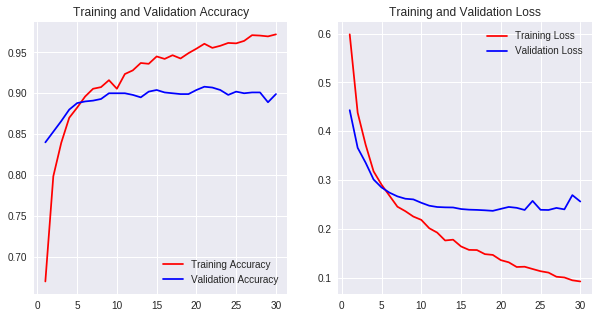

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist.history['acc']) + 1)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, hist.history['acc'],'r-' ,label='Training Accuracy')
plt.plot(epochs, hist.history['val_acc'],'b-' ,label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, hist.history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, hist.history['val_loss'],'b-', label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

plt.show()

결과를 보면 성능은 올라갔지만, 얼마안가 다시 overfitting되는걸 볼 수 있다. <br>
data augmentation이 필요해보이는데, 이는 gpu가 없으면 힘들다.

In [19]:
# 두번째 방식
# gpu필요
# 첫번째 방법보단 느리지만 data augmentation 가능

model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


여기서 convolutional base의 features를 freezing(동결)시켜줘야한다. <br>
그렇지 않으면 dense layer의 가중치 업데이트 과정에서 convolutional base도 업데이트됨. <br>
이러면 pre-trained network를 사용하는 이유가 없어지니까!

In [20]:
# 동결, freezing
# layer당 2개(weight 행렬, bias 벡터)
# VGG가 빠지면서 13개 layer가 빠지고, dense layer 2개만 남음
# 이걸 해주고 compile해줘야함!!

print("conv_base 동결 전 trainable 가중치 수 : ", len(model.trainable_weights))
conv_base.trainable = False
print("conv_base 동결 후 trainable 가중치 수 : ", len(model.trainable_weights))

conv_base 동결 전 trainable 가중치 수 :  30
conv_base 동결 후 trainable 가중치 수 :  4


In [23]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150,150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [25]:
hist = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50, verbose=2)

Epoch 1/30
 - 28s - loss: 0.6074 - acc: 0.6665 - val_loss: 0.4986 - val_acc: 0.7580
Epoch 2/30
 - 26s - loss: 0.4914 - acc: 0.7740 - val_loss: 0.3837 - val_acc: 0.8450
Epoch 3/30
 - 26s - loss: 0.4416 - acc: 0.8070 - val_loss: 0.3368 - val_acc: 0.8680
Epoch 4/30
 - 26s - loss: 0.4124 - acc: 0.8190 - val_loss: 0.3152 - val_acc: 0.8780
Epoch 5/30
 - 26s - loss: 0.3860 - acc: 0.8315 - val_loss: 0.2968 - val_acc: 0.8800
Epoch 6/30
 - 26s - loss: 0.3810 - acc: 0.8335 - val_loss: 0.2915 - val_acc: 0.8840
Epoch 7/30
 - 26s - loss: 0.3649 - acc: 0.8335 - val_loss: 0.2806 - val_acc: 0.8870
Epoch 8/30
 - 26s - loss: 0.3413 - acc: 0.8485 - val_loss: 0.2681 - val_acc: 0.8950
Epoch 9/30
 - 25s - loss: 0.3424 - acc: 0.8520 - val_loss: 0.2658 - val_acc: 0.8950
Epoch 10/30
 - 26s - loss: 0.3381 - acc: 0.8475 - val_loss: 0.2574 - val_acc: 0.8960
Epoch 11/30
 - 25s - loss: 0.3275 - acc: 0.8640 - val_loss: 0.2544 - val_acc: 0.8990
Epoch 12/30
 - 26s - loss: 0.3132 - acc: 0.8590 - val_loss: 0.2580 - val_a

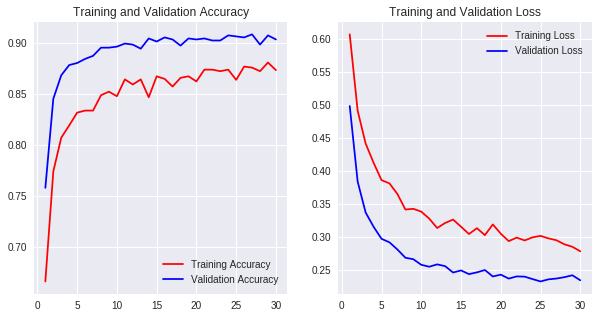

In [26]:
epochs = range(1, len(hist.history['acc']) + 1)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, hist.history['acc'],'r-' ,label='Training Accuracy')
plt.plot(epochs, hist.history['val_acc'],'b-' ,label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, hist.history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, hist.history['val_loss'],'b-', label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

plt.show()

overfitting 폭이 조금 감소된걸 볼 수 있다.